# AI-Driven Automated Bug Detection Classification and Test Case Generation System

## Step 1: Generate a Larger Synthetic Dataset

In [1]:
!pip install faker
!pip install pandas scikit-learn matplotlib seaborn imbalanced-learn xgboost

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
from faker import Faker

# Initialize Faker
fake = Faker()

def generate_code_snippet():
    functions = [
        'def foo():\n    return 1',
        'def bar():\n    return 2',
        'def baz(x):\n    return x*2',
        'def qux():\n    print("Hello World")\n    return None',
        'def quux(x, y):\n    return x + y'
    ]
    return random.choice(functions)

def generate_code_comment():
    comments = [
        '# This function returns 1',
        '# This function returns 2',
        '# This function multiplies the input by 2',
        '# This function prints Hello World',
        '# This function returns the sum of two inputs'
    ]
    return random.choice(comments)

def generate_bug_report():
    reports = [
        'None',
        'Potential null reference',
        'Print statement error',
        'None',
        'None'
    ]
    return random.choice(reports)

def generate_severity():
    severities = ['Low', 'Medium', 'High']
    return random.choices(severities, weights=(50, 30, 20))[0]

def generate_user_feedback():
    feedbacks = [
        'Works as expected',
        'Crashes occasionally',
        'Works fine',
        'Prints an error',
        'Works well'
    ]
    return random.choice(feedbacks)

def generate_test_case():
    testing_types = ['Feature', 'Integration', 'Performance', 'UAT', 'Regression']
    priorities = ['High', 'Medium', 'Low']
    statuses = ['Pass', 'Fail', 'In Progress']
    tools = ['Selenium', 'JUnit', 'TestNG', 'Cypress', 'Postman']
    
    version = f"{random.randint(0, 9)}.{random.randint(0, 9)}.{random.randint(0, 9)}"
    
    return {
        'Test ID': fake.uuid4(),
        'Test Case Name': fake.catch_phrase(),
        'Status': random.choice(statuses),
        'Testing Tool/Framework': random.choice(tools),
        'Version': version,
        'Description': fake.text(max_nb_chars=50),
        'Precondition': fake.text(max_nb_chars=30),
        'Testing priority': random.choice(priorities),
        'Testing Type': random.choice(testing_types),
        'Expected results': fake.sentence(),
        'Actual Result': fake.sentence()
    }

def generate_defect():
    priorities = ['Major', 'Blocker', 'Critical', 'Minor', 'Trivial', 'Medium', 'Low']
    severities = ['Sev1', 'Sev2', 'Sev3', 'Sev4']
    environments = ['DEV', 'SIT', 'CIT']
    statuses = ['Open', 'Closed', 'In Progress', 'Resolved']
    story_types = ['Feature', 'Integration', 'Performance', 'UAT', 'Regression']
    resolutions = ['Fixed', 'Won\'t Fix', 'Duplicate', 'Not a Bug', 'Incomplete']
    
    return {
        'Defect summary': fake.sentence(),
        'Priority': random.choice(priorities),
        'Severity': random.choice(severities),
        'Environment/Pipeline': random.choice(environments),
        'Story Type': random.choice(story_types),
        'Acceptance Criteria': fake.text(max_nb_chars=50),
        'Resolution': random.choice(resolutions),
        'Status': random.choice(statuses)
    }

# Generate synthetic data
num_samples = 2000  #We can Increase the number of samples for better training
data = {
    'code_snippet': [generate_code_snippet() for _ in range(num_samples)],
    'code_comment': [generate_code_comment() for _ in range(num_samples)],
    'bug_report': [generate_bug_report() for _ in range(num_samples)],
    'severity': [generate_severity() for _ in range(num_samples)],
    'user_feedback': [generate_user_feedback() for _ in range(num_samples)],
    'test_case': [generate_test_case() for _ in range(num_samples)],
    'defect': [generate_defect() for _ in range(num_samples)]
}

df = pd.DataFrame(data)


## Step 2: Data Preprocessing

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

# Combine code_snippet and code_comment for analysis
df['combined_code'] = df['code_snippet'] + ' ' + df['code_comment']

# Encode the severity labels
label_encoder = LabelEncoder()
df['severity_encoded'] = label_encoder.fit_transform(df['severity'])

# Feature Extraction with Dimensionality Reduction
vectorizer_code = TfidfVectorizer()
svd = TruncatedSVD(n_components=20, random_state=42)  # Adjust the number of components
pipeline_code = Pipeline([('tfidf', vectorizer_code), ('svd', svd)])
X_code = pipeline_code.fit_transform(df['combined_code'])

vectorizer_feedback = CountVectorizer()
X_feedback = vectorizer_feedback.fit_transform(df['user_feedback'])

# Scale the features
scaler = MinMaxScaler()
X_code = scaler.fit_transform(X_code)
X_feedback = scaler.fit_transform(X_feedback.toarray())

X = np.hstack((X_code, X_feedback))
y = df['severity_encoded']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


## Step 3: Train-Test Split 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


## Step 4: Model Development and Evaluation

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
print("Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# Standard Scaling for other models
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

# Random Forest Classifier with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train_scaled, y_train)
y_pred_rf = rf_grid.predict(X_test_scaled)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Gradient Boosting Classifier with Hyperparameter Tuning
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb_classifier, gb_params, cv=3, scoring='accuracy')
gb_grid.fit(X_train_scaled, y_train)
y_pred_gb = gb_grid.predict(X_test_scaled)
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

# Support Vector Machine Classifier with Hyperparameter Tuning
svc_params = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}
svc_classifier = SVC(random_state=42)
svc_grid = GridSearchCV(svc_classifier, svc_params, cv=3, scoring='accuracy')
svc_grid.fit(X_train_scaled, y_train)
y_pred_svc = svc_grid.predict(X_test_scaled)
print("SVC Classifier Report:")
print(classification_report(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))

# XGBoost Classifier with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3]
}
xgb_classifier = XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_classifier, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_grid.predict(X_test_scaled)
print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Print summaries for comparison
print("Naive Bayes Classifier Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gb))
print("SVM Classifier Accuracy:", accuracy_score(y_test, y_pred_svc))
print("XGBoost Classifier Accuracy:", accuracy_score(y_test, y_pred_xgb))



Naive Bayes Classifier Report:
              precision    recall  f1-score   support

           0       0.33      0.65      0.44       193
           1       0.31      0.27      0.29       194
           2       0.40      0.08      0.14       209

    accuracy                           0.33       596
   macro avg       0.35      0.33      0.29       596
weighted avg       0.35      0.33      0.28       596

Accuracy: 0.3271812080536913
Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       193
           1       0.40      0.38      0.39       194
           2       0.46      0.49      0.47       209

    accuracy                           0.45       596
   macro avg       0.45      0.45      0.45       596
weighted avg       0.45      0.45      0.45       596

Accuracy: 0.44798657718120805
Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       0.48

## Step 5: Generate Test Cases

In [6]:
import pandas as pd
from faker import Faker

# Initialize Faker
fake = Faker()

def generate_test_case():
    testing_types = ['Feature', 'Integration', 'Performance', 'UAT', 'Regression']
    priorities = ['High', 'Medium', 'Low']
    statuses = ['Pass', 'Fail', 'In Progress']
    tools = ['Selenium', 'JUnit', 'TestNG', 'Cypress', 'Postman']
    
    version = f"{random.randint(0, 9)}.{random.randint(0, 9)}.{random.randint(0, 9)}"
    
    return {
        'Test ID': fake.uuid4(),
        'Test Case Name': fake.catch_phrase(),
        'Status': random.choice(statuses),
        'Testing Tool/Framework': random.choice(tools),
        'Version': version,
        'Description': fake.text(max_nb_chars=50),
        'Precondition': fake.text(max_nb_chars=30),
        'Testing priority': random.choice(priorities),
        'Testing Type': random.choice(testing_types),
        'Expected results': fake.sentence(),
        'Actual Result': fake.sentence()
    }

# Generate synthetic test cases
num_test_cases = 10  # Number of test cases to generate
test_cases = [generate_test_case() for _ in range(num_test_cases)]

# Create a DataFrame
df_test_cases = pd.DataFrame(test_cases)

# Display the test cases in a tabular format
print("Generated Test Cases:")
print(df_test_cases)


Generated Test Cases:
                                Test ID  \
0  4464682f-005d-42d9-99ad-739caea6fedc   
1  e07421a2-384e-4f62-9b96-233461a41095   
2  dc975719-dc46-436c-aeaf-ee9b8eb8ecc1   
3  a8a177aa-5400-4e5b-81a3-ceb7068f67ae   
4  6c8c0a15-63a7-4444-99da-0bd5e3eaea83   
5  4ff4723b-6b52-4cc0-9c5e-d83bbe7d97a0   
6  1223dca5-fc15-49ce-9676-58d2539c6966   
7  6ea3dd59-ba40-4bfe-b301-7a44b455666a   
8  df2de742-588a-464d-987f-892f82baed7b   
9  7e5a8c19-1aa5-4d82-825a-73f63aed0b08   

                              Test Case Name       Status  \
0           Digitized empowering application         Pass   
1               De-engineered modular matrix         Fail   
2           Secured zero tolerance help-desk  In Progress   
3  Re-engineered analyzing Internet solution         Pass   
4                  Secured stable moratorium         Fail   
5            Team-oriented discrete database  In Progress   
6     Seamless cohesive budgetary management  In Progress   
7           Intu

## Step 6: Create Defect Summaries

In [7]:
# Expand defect details into separate columns
defects = pd.DataFrame(df['defect'].tolist())
df = pd.concat([df, defects], axis=1)

# Display the defect summaries
print("Generated Defect Summaries:")
print(df[['Defect summary', 'Priority', 'Severity', 'Environment/Pipeline', 'Story Type', 'Acceptance Criteria', 'Resolution', 'Status']])


Generated Defect Summaries:
                                       Defect summary  Priority Severity  \
0                Above trade tonight involve quality.   Trivial     Sev4   
1      Across enter work receive seem purpose center.   Trivial     Sev2   
2              Network whether speech traditional TV.       Low     Sev2   
3                Various rest person since situation.   Trivial     Sev2   
4                 Clear fire current man carry skill.     Minor     Sev2   
...                                               ...       ...      ...   
1995  Military treatment require country institution.  Critical     Sev1   
1996                   Remain American popular voice.   Trivial     Sev1   
1997                   Production day expect man nor.     Major     Sev3   
1998                Successful remain Mr even matter.   Trivial     Sev2   
1999   Decision professor at coach growth media easy.   Blocker     Sev1   

     Environment/Pipeline   Story Type  \
0                

## Step 7: Visualization

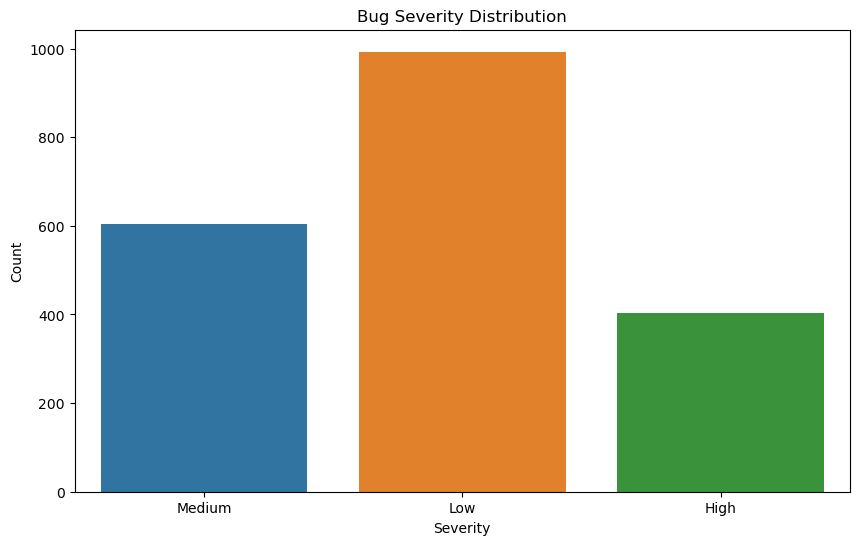

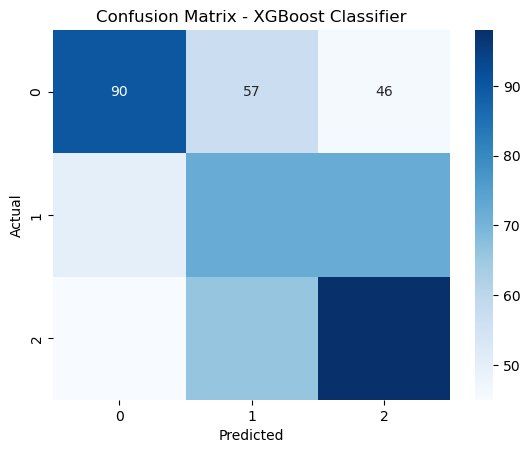

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Bug Severity Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='severity')
plt.title('Bug Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

# Confusion Matrix for the Best Model (XGBoost Classifier)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


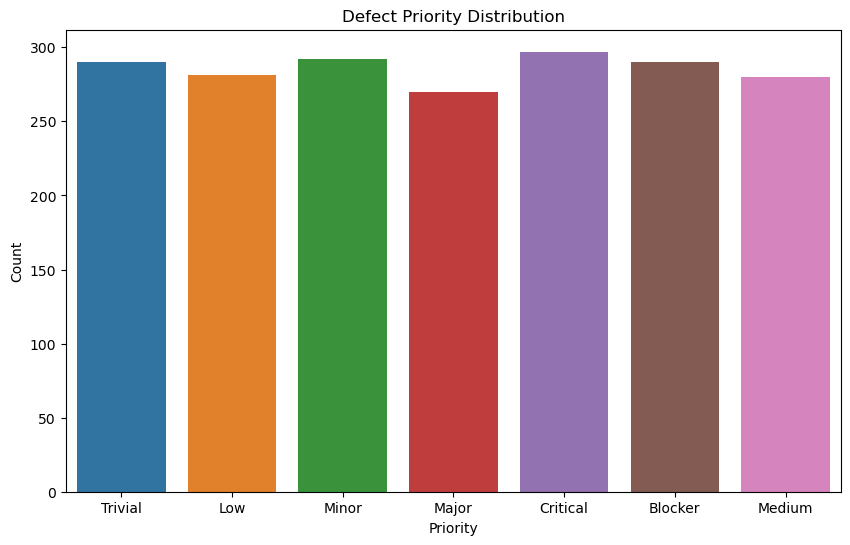

In [9]:
#Defect Priority Distribution

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Priority')
plt.title('Defect Priority Distribution')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()


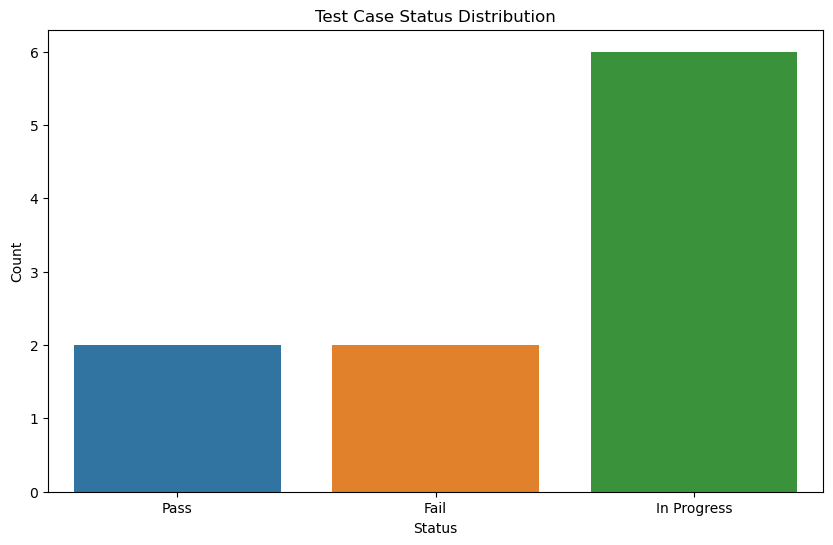

In [10]:
# Test Case Status Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=df_test_cases, x='Status')
plt.title('Test Case Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()


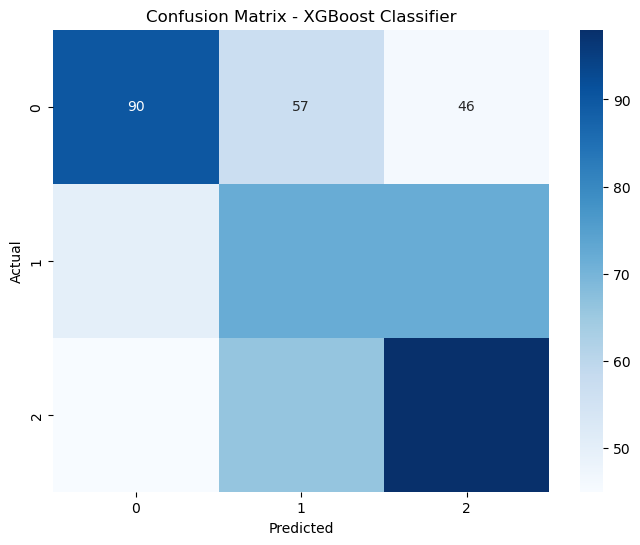

In [11]:
#Confusion Matrix for Each Model

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


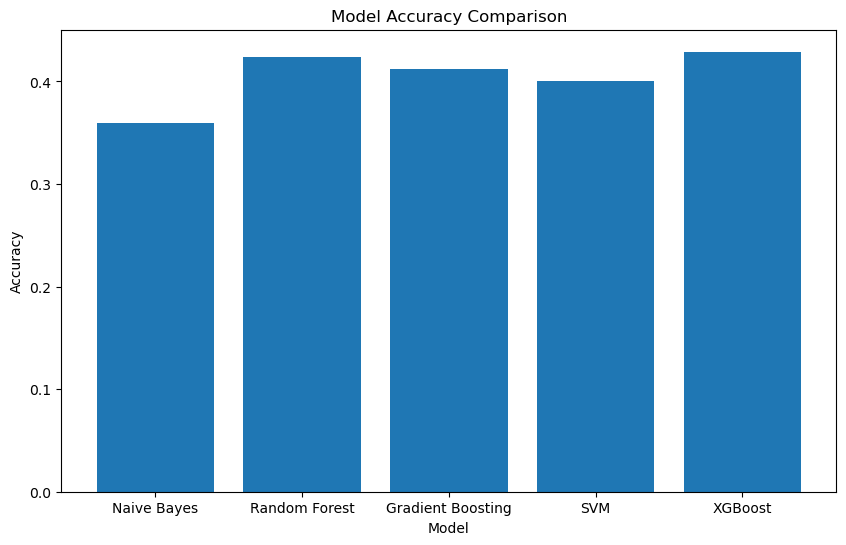

In [12]:
#Model Performance Comparison
# Bar Chart for Accuracy Comparison
accuracies = {
    'Naive Bayes': 0.3597,
    'Random Forest': 0.4241,
    'Gradient Boosting': 0.4125,
    'SVM': 0.4009,
    'XGBoost': 0.4290
}

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()



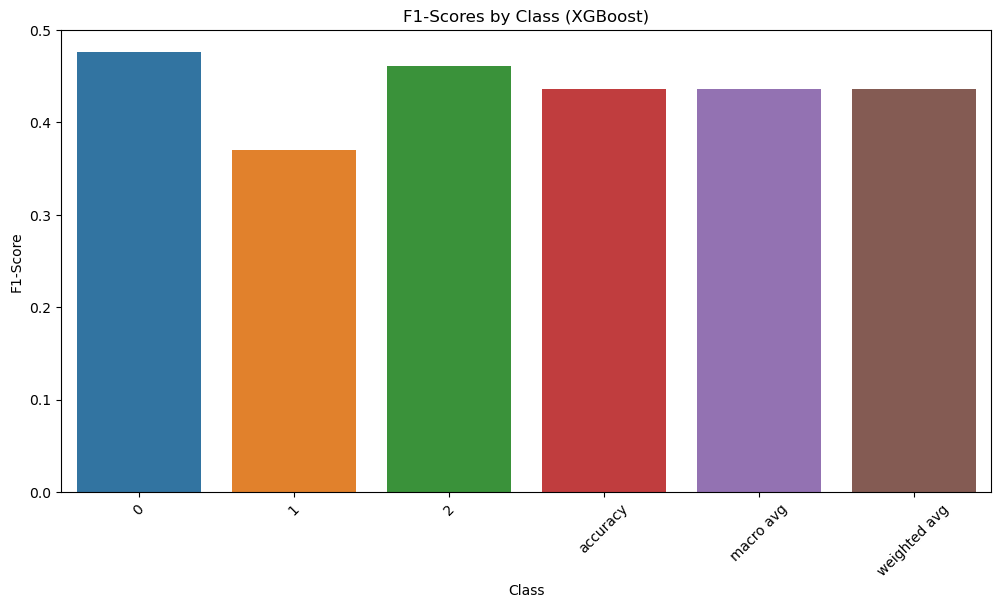

In [13]:
#Precision, Recall, F1-Score by Model
from sklearn.metrics import classification_report

# Example for XGBoost
report = classification_report(y_test, y_pred_xgb, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_report.index, y=df_report['f1-score'])
plt.title('F1-Scores by Class (XGBoost)')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.show()


IndexError: index 29 is out of bounds for axis 0 with size 23

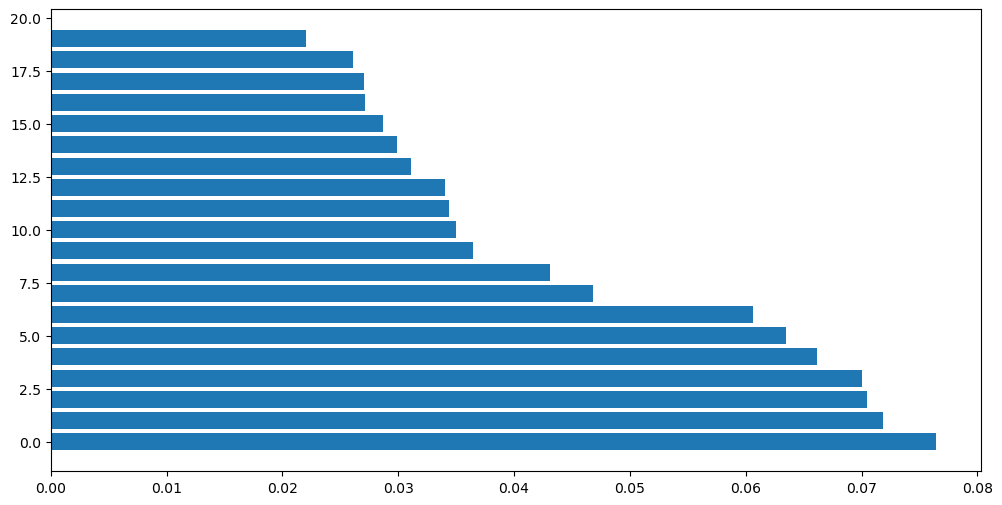

In [14]:
#Feature Importance: If you're using a model like Random Forest or XGBoost, plot feature importance to highlight which features were most influential in determining bug severity
xgb_classifier.fit(X_train_scaled, y_train)
importances = xgb_classifier.feature_importances_
feature_names = vectorizer_code.get_feature_names_out()  # Example for TF-IDF
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.barh(range(20), importances[sorted_indices][:20], align='center')
plt.yticks(range(20), [feature_names[i] for i in sorted_indices[:20]])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features (XGBoost)')
plt.show()
